Data Source: https://www.coingecko.com/id/coins/tron/historical_data <br>
2017-11-09 to 2025-05-24

# Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.ticker import MultipleLocator
import scipy.stats as stats
from scipy.stats import chi2
import pylab
import warnings
warnings.filterwarnings('ignore')

# Import Data

In [5]:
df= pd.read_csv('trx-usd-max.csv', index_col='snapped_at', parse_dates=True)
df_tron = df.copy()
df_tron

,price,market_cap,total_volume
snapped_at,,,
2017-11-09 00:00:00+00:00,0.002387,1.564042e+08,1.224287e+06
2017-11-10 00:00:00+00:00,0.002044,1.339685e+08,9.904228e+05
2017-11-11 00:00:00+00:00,0.001915,1.254706e+08,7.076430e+05
2017-11-12 00:00:00+00:00,0.001804,1.182352e+08,8.147892e+05
2017-11-13 00:00:00+00:00,0.002018,1.323864e+08,8.949856e+05
...,...,...,...
2025-05-20 00:00:00+00:00,0.266617,2.529668e+10,8.399491e+08
2025-05-21 00:00:00+00:00,0.268929,2.551096e+10,9.806264e+08
2025-05-22 00:00:00+00:00,0.268624,2.548787e+10,9.674796e+08


# Checking missing Values

In [7]:
df_tron.isnull().sum()

price           0
market_cap      0
total_volume    0
dtype: int64

# Set Frequency

In [9]:
df_tron.asfreq('d')
df_tron.isnull().sum()

price           0
market_cap      0
total_volume    0
dtype: int64

# Exploratory Data Analysis Time Series

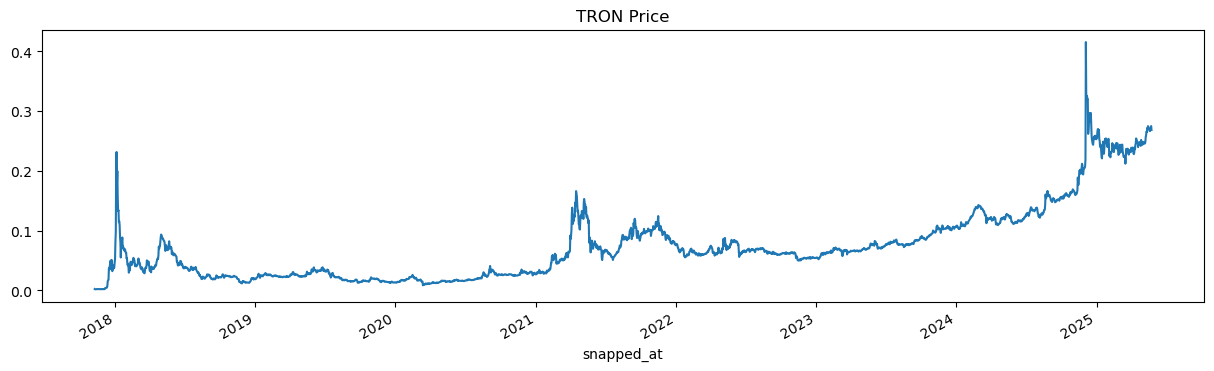

In [11]:
plt.figure(figsize=(15, 4))
df_tron["price"].plot(title='TRON Price')
plt.show()

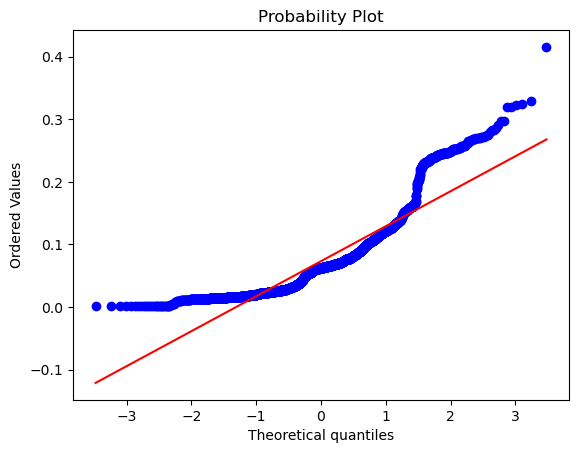

In [12]:
stats.probplot(df_tron['price'], plot=pylab)
pylab.show()

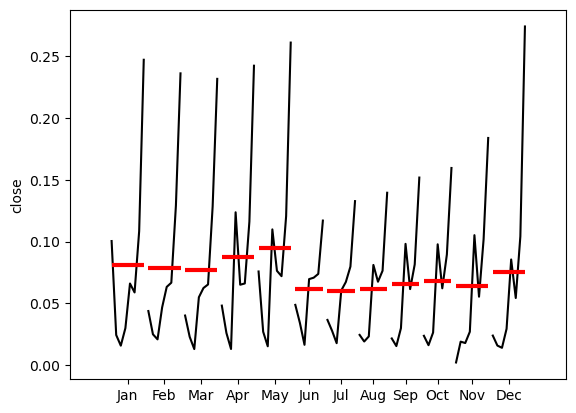

In [13]:
#montly seasonality
month_plot(df_tron["price"].resample("ME").mean(),
          ylabel='close')
plt.show()

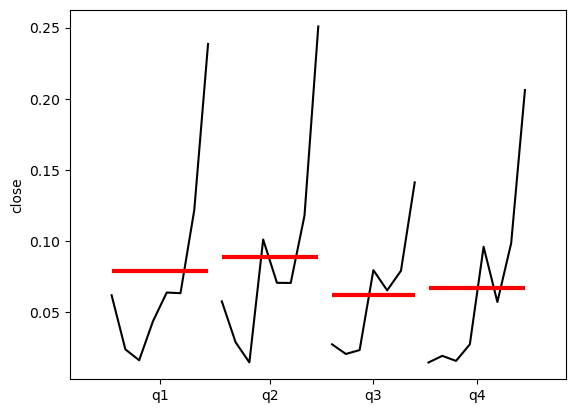

In [14]:
#quarter plot
quarter_plot(df_tron["price"].resample("QE").mean(),
          ylabel='close')
plt.show()

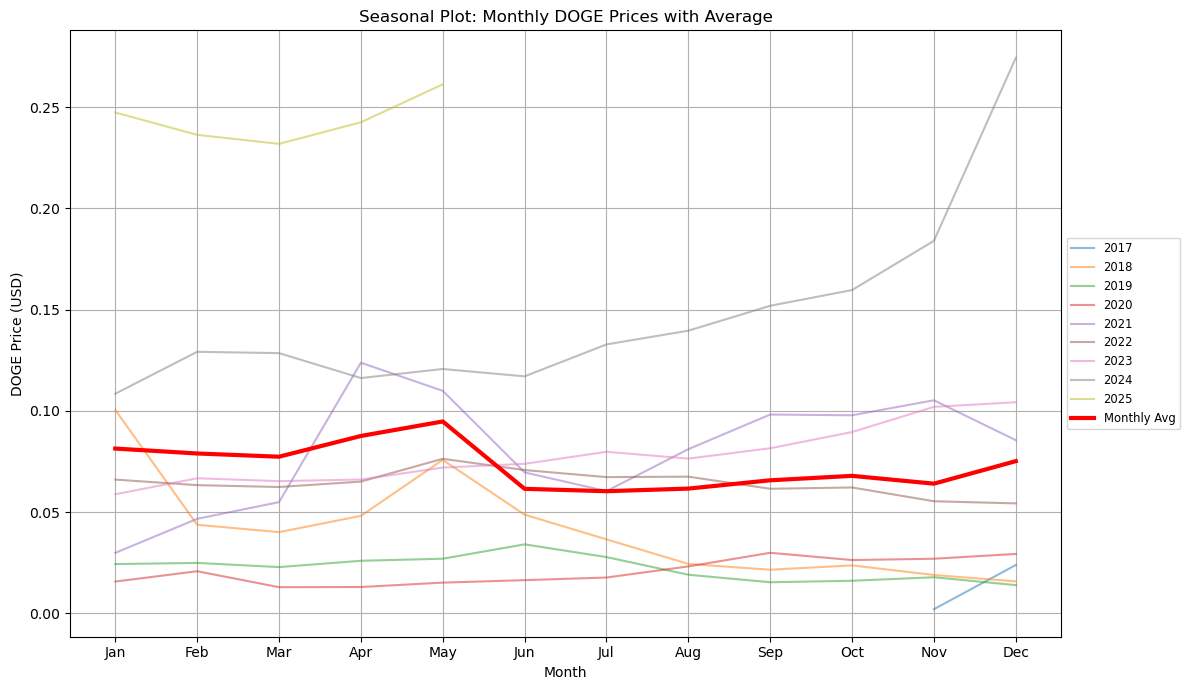

In [15]:
# MONTLY
# Ensure the index is datetime (just in case)
df_tron.index = pd.to_datetime(df_tron.index)

# Extract year and month from the index
df_tron['Year'] = df_tron.index.year
df_tron['Month'] = df_tron.index.strftime('%b')

# Create the pivot table
pivot_df = df_tron.pivot_table(index='Month', columns='Year', values='price', aggfunc='mean')

# Reorder the months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
pivot_df = pivot_df.reindex(month_order)

plt.figure(figsize=(12, 7))

for year in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[year], label=str(year), alpha=0.5)

monthly_avg = pivot_df.mean(axis=1)
plt.plot(pivot_df.index, monthly_avg, color='red', linewidth=3, label='Monthly Avg')

plt.title('Seasonal Plot: Monthly DOGE Prices with Average')
plt.xlabel('Month')
plt.ylabel('DOGE Price (USD)')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

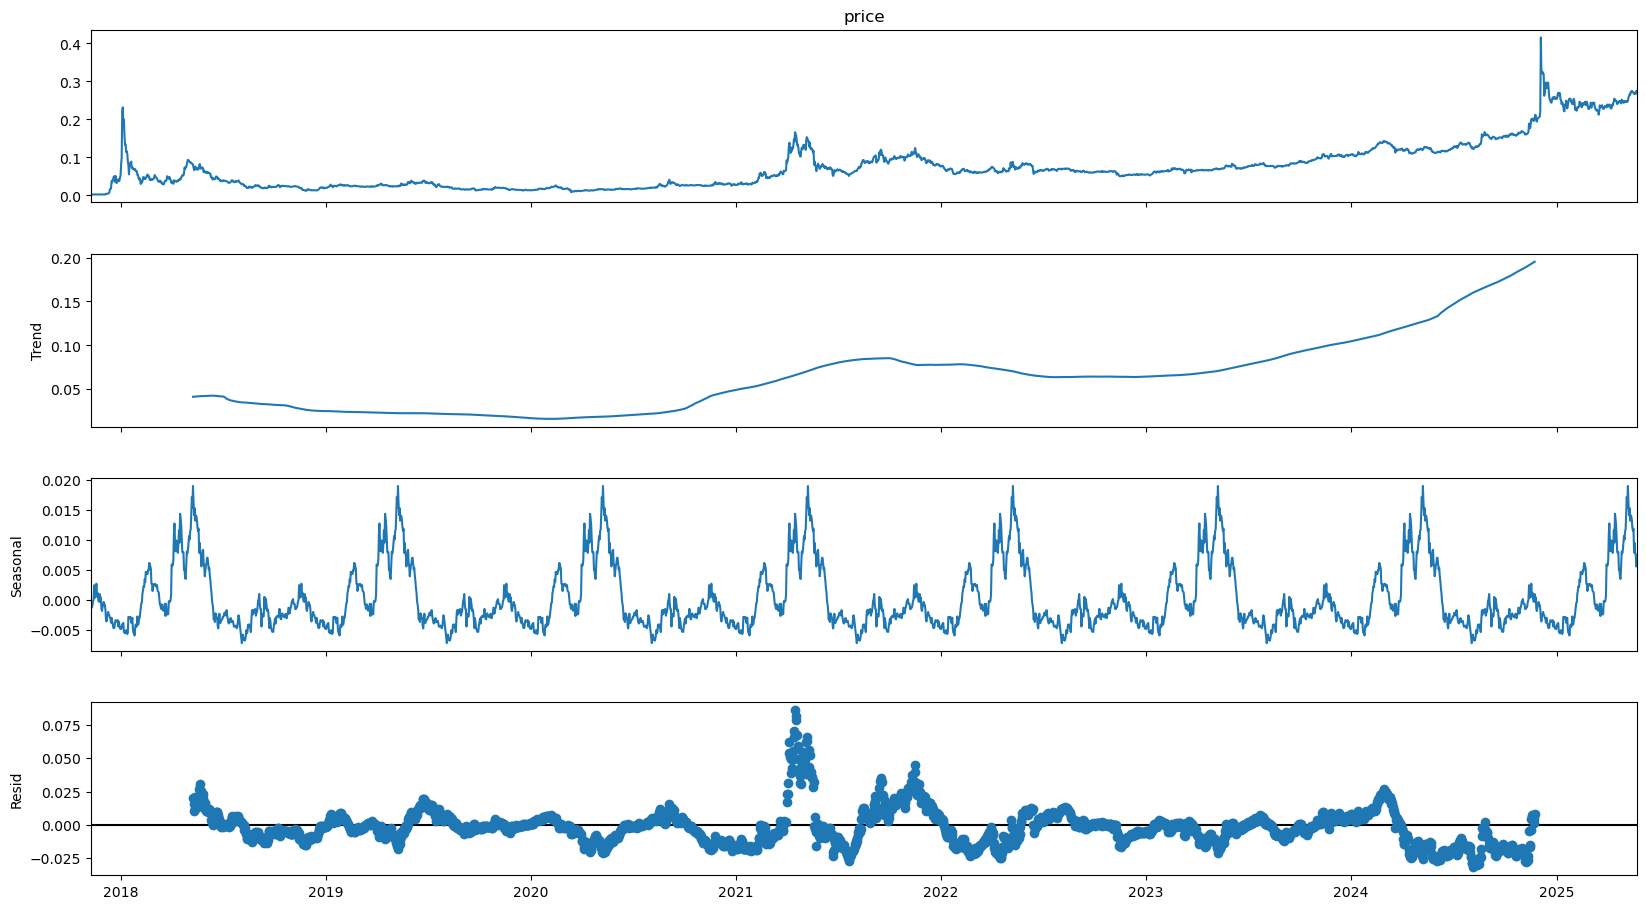

In [16]:
# Seasonal decomposition for df['Adj. Close']
decomposition = seasonal_decompose(df_tron['price'],
                                  model = 'add',
                                  period = 365)
fig = decomposition.plot()
fig.set_size_inches(18, 10)
plt.show()

# Split The Data

In [18]:
size = int(len(df_tron)*0.90) #90/10 split
tron_train = df_tron.iloc[:size]
tron_test = df_tron.iloc[size:]
tron_train

,price,market_cap,total_volume,Year,Month
snapped_at,,,,,
2017-11-09 00:00:00+00:00,0.002387,1.564042e+08,1.224287e+06,2017,Nov
2017-11-10 00:00:00+00:00,0.002044,1.339685e+08,9.904228e+05,2017,Nov
2017-11-11 00:00:00+00:00,0.001915,1.254706e+08,7.076430e+05,2017,Nov
2017-11-12 00:00:00+00:00,0.001804,1.182352e+08,8.147892e+05,2017,Nov
2017-11-13 00:00:00+00:00,0.002018,1.323864e+08,8.949856e+05,2017,Nov
...,...,...,...,...,...
2024-08-17 00:00:00+00:00,0.134077,1.166188e+10,4.392101e+08,2024,Aug
2024-08-18 00:00:00+00:00,0.134861,1.172729e+10,3.483550e+08,2024,Aug
2024-08-19 00:00:00+00:00,0.134925,1.173662e+10,2.975156e+08,2024,Aug


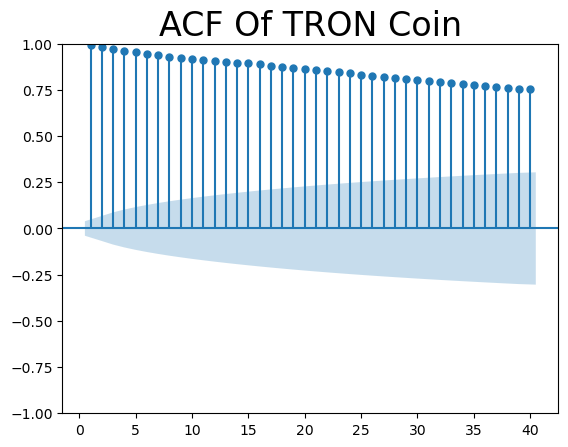

In [19]:
sgt.plot_acf(tron_train.price, zero = False, lags = 40)
plt.title('ACF Of TRON Coin',size = 24)
plt.show()

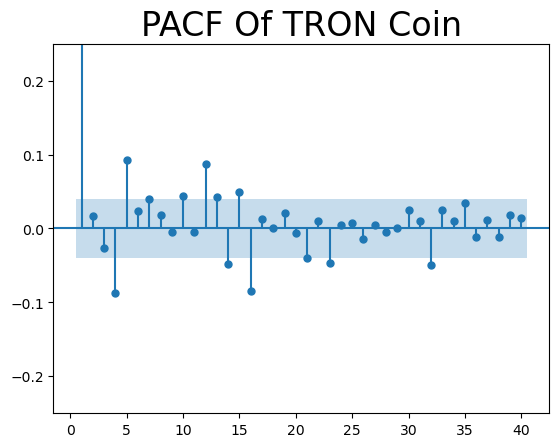

In [20]:
sgt.plot_pacf(tron_train.price, zero = False, lags = 40)
plt.title('PACF Of TRON Coin',size = 24)
plt.ylim(-0.25,0.25)
plt.show()

# Stationarity and differencing

In [22]:
tron_train['log_returns'] = np.log(tron_train['price'] / tron_train['price'].shift(1))
tron_test['log_returns'] = np.log(tron_test['price'] / tron_test['price'].shift(1))

In [23]:
adf_result = adfuller(tron_train.log_returns[1:])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] <= 0.05:
    print("✅ Series is stationary")
else:
    print("⚠️ Series is NOT stationary. Consider differencing.")

ADF Statistic: -8.140091386959119
p-value: 1.0337477860678628e-12
✅ Series is stationary


# Parameter tunning for ARMA

In [25]:
# Define LLR test
def LLR_test(model1, model2, df=1):
    llf1 = model1.llf
    llf2 = model2.llf
    LR = 2 * (llf2 - llf1)
    p = chi2.sf(LR, df).round(4)
    return p

data = tron_train['log_returns'].dropna()

best_aic = float('inf')
best_order = None
best_model = None

print(f"{'Order':<10}{'AIC':<12}{'BIC':<12}{'LLR p-val'}")

for p in range(6):
    for q in range(6):
        try:
            model = ARIMA(data, order=(p, 0, q)).fit()
            aic = model.aic
            bic = model.bic
            order = (p, q)

            # LLR test if previous model exists
            if best_model:
                llr_pval = LLR_test(best_model, model)
                llr_str = f"{llr_pval:.4f}"
            else:
                llr_str = "---"

            print(f"{str(order):<10}{aic:<12.2f}{bic:<12.2f}{llr_str}")

            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_model = model

        except Exception as e:
            continue

print("\nBest ARMA order (p, q):", best_order)
print("Best AIC:", best_aic)

Order     AIC         BIC         LLR p-val
(0, 0)    -6708.97    -6697.34    ---
(0, 1)    -6706.98    -6689.54    0.9187
(0, 2)    -6733.10    -6709.84    0.0000
(0, 3)    -6755.37    -6726.30    0.0000
(0, 4)    -6753.59    -6718.71    0.6380
(0, 5)    -6752.55    -6711.85    0.2774
(1, 0)    -6706.99    -6689.54    1.0000
(1, 1)    -6705.74    -6682.48    1.0000
(1, 2)    -6751.28    -6722.20    1.0000
(1, 3)    -6753.72    -6718.83    0.5546
(1, 4)    -6751.58    -6710.87    0.6517
(1, 5)    -6749.64    -6703.12    0.6060
(2, 0)    -6732.17    -6708.91    1.0000
(2, 1)    -6703.10    -6674.02    1.0000
(2, 2)    -6749.62    -6714.73    1.0000
(2, 3)    -6752.23    -6711.53    0.3537
(2, 4)    -6751.49    -6704.97    0.1453
(2, 5)    -6747.92    -6695.59    0.4598
(3, 0)    -6757.08    -6728.00    0.1915
(3, 1)    -6755.23    -6720.34    0.6998
(3, 2)    -6753.97    -6713.26    0.3455
(3, 3)    -6752.16    -6705.64    0.2993
(3, 4)    -6749.61    -6697.28    0.4656
(3, 5)    -6779.

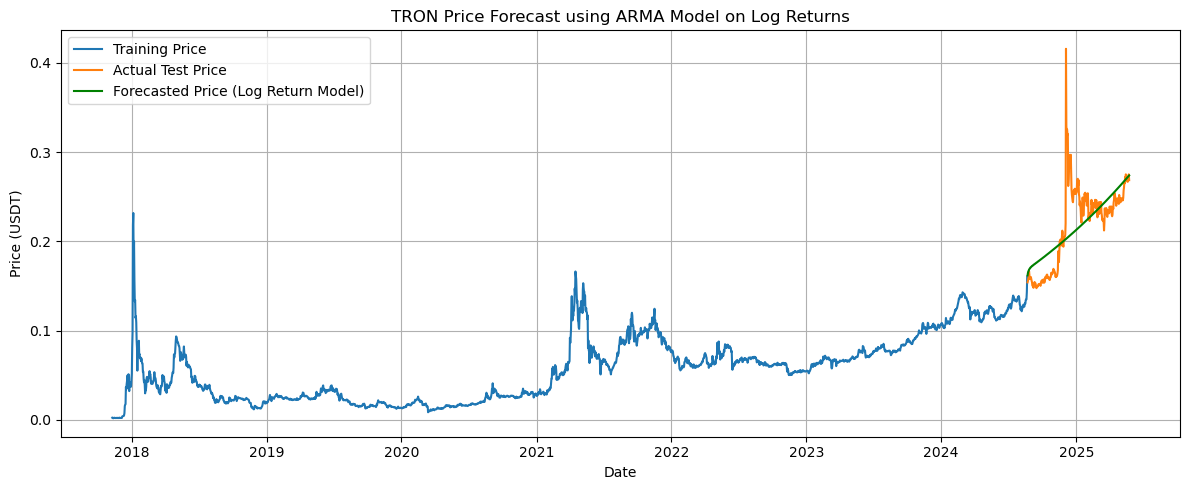

In [33]:
# ===Fit ARMA model with the best parameters===
model = ARIMA(data, order=(3, 0, 5))  
results = model.fit()

# === Forecast log returns ===
forecast_steps = len(tron_test)
forecasted_log_returns = results.forecast(steps=forecast_steps)

# ===  Convert log returns to prices ===
last_log_price = np.log(tron_train['price'].iloc[-1])
forecasted_log_price = forecasted_log_returns.cumsum() + last_log_price
forecasted_price = np.exp(forecasted_log_price)

# === Align and plot ===
forecast_series = pd.Series(data=forecasted_price.values, index=tron_test.index[:forecast_steps])

# Plot
plt.figure(figsize=(12, 5))
plt.plot(tron_train['price'], label="Training Price")
plt.plot(tron_test['price'], label="Actual Test Price")
plt.plot(forecast_series, label="Forecasted Price (Log Return Model)", color='green')
plt.title("TRON Price Forecast using ARMA Model on Log Returns")
plt.xlabel("Date")
plt.ylabel("Price (USDT)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
